In [93]:
# !pip install numpy pandas scikit-learn tensorflow torch transformers spacy

### BIO Tagging

In [94]:
# !pip install chardet


In [95]:
import os
import chardet

def detect_file_encoding(file_path):
    """Detect the encoding of a file."""
    with open(file_path, 'rb') as f:  # Open in binary mode
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

def prepare_hf_dataset(parent_folder):
    """Prepare the dataset from all year folders in the given parent folder."""
    dataset = {"tokens": [], "tags": []}
    
    # Iterate over all year folders in the parent folder
    for year_folder in os.listdir(parent_folder):
        year_path = os.path.join(parent_folder, year_folder)
        if os.path.isdir(year_path):  # Check if it's a folder
            for file in os.listdir(year_path):
                if file.endswith(".final"):
                    file_path = os.path.join(year_path, file)
                    # print(f"Processing file: {file_path}")  # Debugging
                    
                    # Detect encoding
                    try:
                        encoding = detect_file_encoding(file_path)
                        # print(f"Detected encoding for {file_path}: {encoding}")
                        with open(file_path, 'r', encoding=encoding) as f:
                            tokens, tags = [], []
                            for line in f:
                                if line.strip():  # Non-empty line
                                    parts = line.strip().split()
                                    if len(parts) == 2:
                                        word, tag = parts
                                        tokens.append(word)
                                        tags.append(tag)
                                else:  # Empty line signals end of a sentence
                                    if tokens and tags:
                                        dataset["tokens"].append(tokens)
                                        dataset["tags"].append(tags)
                                        tokens, tags = [], []  # Reset for next sentence
                            # Ensure the last sentence in the file is added
                            if tokens and tags:
                                dataset["tokens"].append(tokens)
                                dataset["tags"].append(tags)
                    except UnicodeDecodeError as e:
                        print(f"Error processing file {file_path}: {e}")
    
    return dataset

# Test the function
dataset_dir = os.getcwd() + "\\Combine_Dataset"
dataset = dict({})

for dir in os.scandir(dataset_dir):
    if dir.is_dir():
        try:
            # Attempt to prepare the dataset for this directory
            dataset[dir.name] = prepare_hf_dataset(f"{dataset_dir}\\{str(dir.name)}")
            
            # Save the dataset to a JSON file
            output_file = f"{dir.name}_dataset.json"
            with open(output_file, 'w', encoding='utf-8', errors='replace') as f:
                json.dump(dataset[dir.name], f)
            print(f"Dataset saved to {output_file}")
        
        except UnicodeDecodeError as e:
            print(f"Skipping directory {dir.name} due to encoding issue: {e}")
        except Exception as e:
            print(f"An error occurred with directory {dir.name}: {e}")

Dataset saved to dev_dataset.json
Dataset saved to test_dataset.json
Error processing file D:\Y4 T1\NLP\Project\Combine_Dataset\train\2021\2021-47-2-445-476.final: 'charmap' codec can't decode byte 0x9d in position 342: character maps to <undefined>
Dataset saved to train_dataset.json


In [96]:
import pandas as pd
train_df = pd.read_json("train_dataset.json")
test_df = pd.read_json("test_dataset.json")
dev_df = pd.read_json("dev_dataset.json")

print(f"Train Size: {len(train_df)}")
print(f"Test Size: {len(test_df)}")
print(f"Dev Size: {len(dev_df)}")

def labels_lower_to_upper(df):
    for i, tags in enumerate(df.tags):
        for tag in tags:
            if tag.islower():
                df['tags'][i][tags.index(tag)] = tag.upper()

labels_lower_to_upper(train_df)
labels_lower_to_upper(test_df)
labels_lower_to_upper(dev_df)

Train Size: 503
Test Size: 60
Dev Size: 49


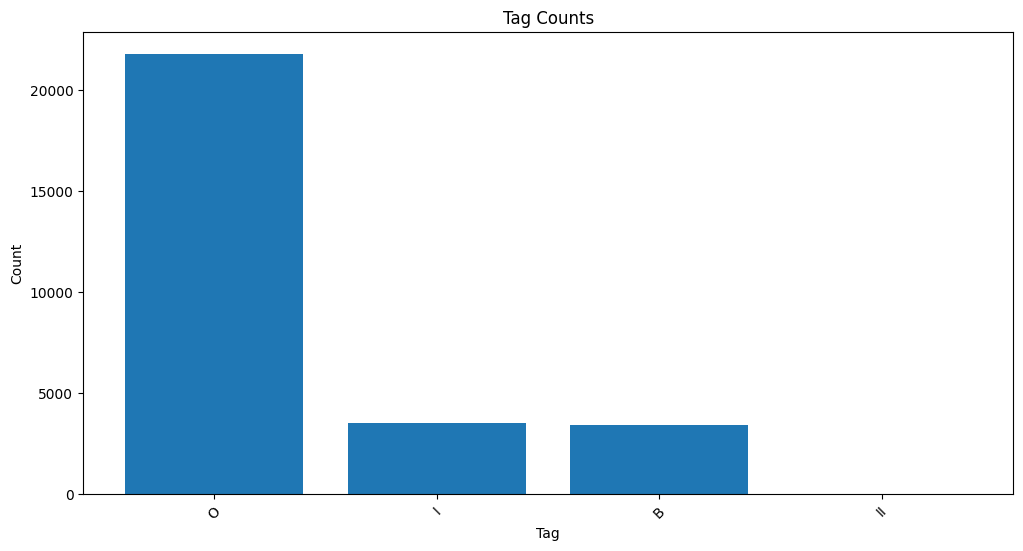

In [97]:
#plot the tags
import matplotlib.pyplot as plt
import numpy

# Count the number of occurrences of each tag
tag_counts = {}
for tags in train_df["tags"]:
    for tag in tags:
        if tag not in tag_counts:
            tag_counts[tag] = 0
        tag_counts[tag] += 1
        
# Sort the tags by count
sorted_tag_counts = dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the tag counts
plt.figure(figsize=(12, 6))
plt.bar(sorted_tag_counts.keys(), sorted_tag_counts.values())
plt.xticks(rotation=45)
plt.xlabel("Tag")
plt.ylabel("Count")
plt.title("Tag Counts")
plt.show()

In [98]:
def clean_labels(df):
    for i, tags in enumerate(df.tags):
        for tag in tags:
            if tag.islower():
                df['tags'][i][tags.index(tag)] = tag.upper()
            if len(tag) > 1:
                df['tags'][i][tags.index(tag)] = tag[0]
            if tag=='0':
                df['tags'][i][tags.index(tag)] = 'O'

clean_labels(train_df)
clean_labels(test_df)
clean_labels(dev_df)

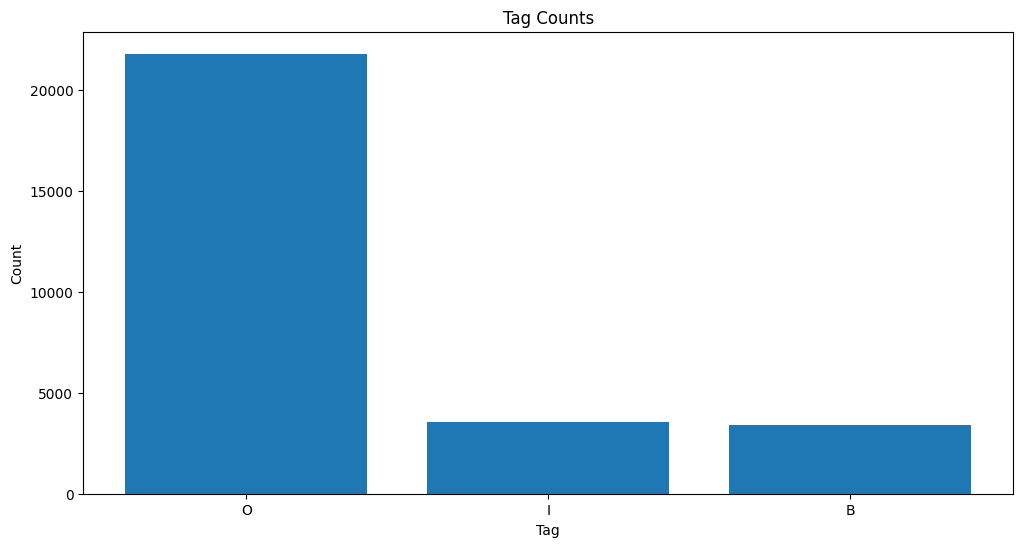

In [99]:
#plot the tags
import matplotlib.pyplot as plt
import numpy

# Count the number of occurrences of each tag
tag_counts = {}
for tags in train_df["tags"]:
    for tag in tags:
        if tag not in tag_counts:
            tag_counts[tag] = 0
        tag_counts[tag] += 1
        
# Sort the tags by count
sorted_tag_counts = dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the tag counts
plt.figure(figsize=(12, 6))
plt.bar(sorted_tag_counts.keys(), sorted_tag_counts.values())
# plt.xticks(rotation=45)
plt.xlabel("Tag")
plt.ylabel("Count")
plt.title("Tag Counts")
plt.show()

In [100]:
#print the extract number of each tags
print(sorted_tag_counts)


{'O': 21797, 'I': 3530, 'B': 3414}


### Mapping Tags to Numbers

In [101]:
# BIO_MAP = {
#     'O': 0,
#     'B': 1,
#     'I': 2
# }
# 
# def map_labels(df, mapper):
#     for i, tags in enumerate(df['tags']):
#         for j, tag in enumerate(tags):
#             if not str(tag).isdigit():  # Check that the tag is not a digit
#                 if tag in mapper:
#                     df['num_tags'][i][j] = mapper[tag]  # Assign mapped value
#                 else:
#                     raise KeyError(f"Tag '{tag}' not found in mapper")
# 
# map_labels(train_df, BIO_MAP)
# map_labels(test_df, BIO_MAP)
# map_labels(dev_df, BIO_MAP)
# 
# #drop column num_tags
# train_df = train_df.drop(columns=['num_tags'])

# BIO_MAP = {
#     'O': 0,
#     'B': 1,
#     'I': 2
# }
# 
# def convert_bio_to_numeric(bio_tags, bio_map):
#     return [bio_map[tag] for tag in bio_tags]
# 
# train_df['num_tags'] = train_df['tags'].apply(lambda x: convert_bio_to_numeric(x, BIO_MAP))
# test_df['num_tags'] = test_df['tags'].apply(lambda x: convert_bio_to_numeric(x, BIO_MAP))
# dev_df['num_tags'] = dev_df['tags'].apply(lambda x: convert_bio_to_numeric(x, BIO_MAP))

In [102]:
# train_df

### Convert data to hugging face format

In [103]:
# Convert the data into a Hugging Face dataset
from datasets import Dataset
dev_hugging_face_dat = Dataset.from_dict({
    "tokens": dev_df["tokens"],
    "tags": dev_df["tags"]
})

train_hugging_face_dat = Dataset.from_dict({
    "tokens": train_df["tokens"],
    "tags": train_df["tags"]
})

test_hugging_face_dat = Dataset.from_dict({
    "tokens": test_df["tokens"],
    "tags": test_df["tags"]
})



### Feature Extraction

In [104]:
def extract_features(tokens, idx):
    word = tokens[idx]
    features = {
        'word': word,  # Current word
        'is_upper': word.isupper(),  # Is the word uppercase?
        'is_title': word.istitle(),  # Is the word title case?
        'is_digit': word.isdigit(),  # Is the word a digit?
        'word_len': len(word),  # Length of the word
    }
    
    # Previous word features
    if idx > 0:
        features['prev_word'] = tokens[idx - 1]
    else:
        features['prev_word'] = "<START>"
    
    # Next word features
    if idx < len(tokens) - 1:
        features['next_word'] = tokens[idx + 1]
    else:
        features['next_word'] = "<END>"
    
    return features

def prepare_data_for_crf(dataset):
    features = []
    labels = []
    
    for example in dataset:
        tokens = example['tokens']
        tags = example['tags']
        
        # Extract features for each token
        sentence_features = [extract_features(tokens, idx) for idx in range(len(tokens))]
        features.append(sentence_features)
        labels.append(tags)
    
    return features, labels


In [105]:
# Example: Assuming train_dataset is the Hugging Face dataset
train_features, train_labels = prepare_data_for_crf(train_hugging_face_dat)
test_features, test_labels = prepare_data_for_crf(test_hugging_face_dat)


In [106]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Initialize the CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',  # Use LBFGS optimization
    max_iterations=100,  # Maximum iterations
    all_possible_transitions=True  # Allow all transitions between tags
)

# Train the model
crf.fit(train_features, train_labels)


CRF(algorithm='lbfgs', all_possible_transitions=True, max_iterations=100)

In [107]:
# Make predictions on the test set
predicted_labels = crf.predict(test_features)

# Evaluate the model's performance
print(metrics.flat_classification_report(test_labels, predicted_labels))


              precision    recall  f1-score   support

           B       0.62      0.45      0.52       451
           I       0.69      0.65      0.67       488
           O       0.89      0.94      0.91      3205

    accuracy                           0.85      4144
   macro avg       0.74      0.68      0.70      4144
weighted avg       0.84      0.85      0.84      4144



In [108]:
# Hyperparameter tuning example (you can use grid search for this)
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(train_features, train_labels)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [109]:
def predict_tags(tokens):
    features = [extract_features(tokens, idx) for idx in range(len(tokens))]  # Extract features for the new tokens
    predicted_tags = crf.predict([features])  # Get predicted tags
    return predicted_tags[0]

# Example usage
new_tokens = ["This", "is", "an", "natural", "language"]
predicted_tags = predict_tags(new_tokens)
print(list(zip(new_tokens, predicted_tags)))


[('This', 'O'), ('is', 'O'), ('an', 'O'), ('natural', 'B'), ('language', 'I')]


In [110]:
# Make predictions on the test set
predicted_labels = crf.predict(test_features)

# Evaluate the model's performance
print(metrics.flat_classification_report(test_labels, predicted_labels))


              precision    recall  f1-score   support

           B       0.66      0.54      0.60       451
           I       0.73      0.68      0.70       488
           O       0.91      0.94      0.92      3205

    accuracy                           0.87      4144
   macro avg       0.77      0.72      0.74      4144
weighted avg       0.86      0.87      0.86      4144



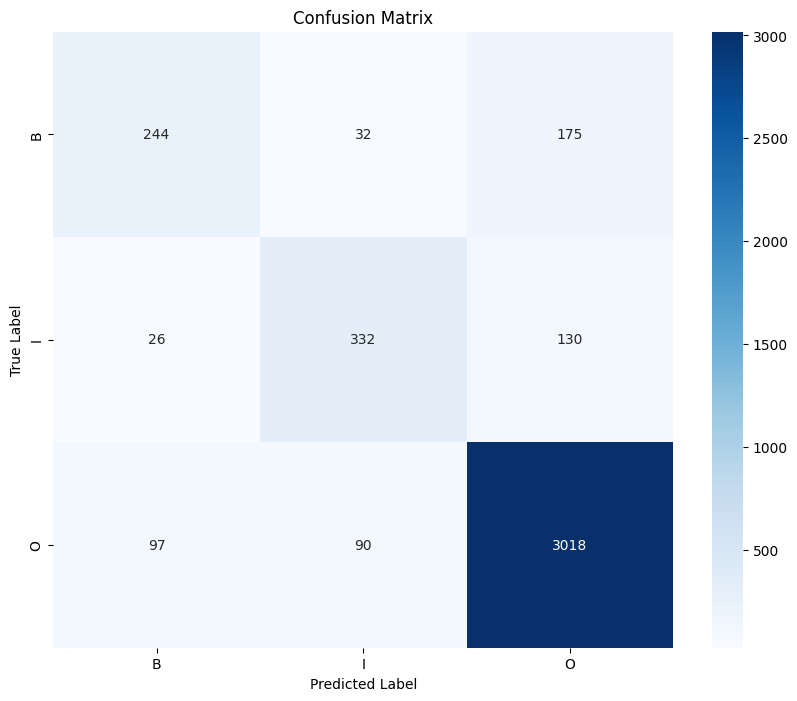

In [111]:
# plot confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a DataFrame from the confusion matrix
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
# Get the unique tags
unique_tags = list(set(tag for tags in test_labels for tag in tags))

# Plot the confusion matrix
plot_confusion_matrix([tag for tags in test_labels for tag in tags], [tag for tags in predicted_labels for tag in tags], unique_tags)



In [112]:
# save the model
import joblib
joblib.dump(crf, 'crf_model.pkl')


['crf_model.pkl']